# Header

DKE가 뭔지 여기서 차근차근 알아보도록 하자. 
paper가 준 data를 받아서 어떻게 만들었는지 알아보자.

In [2]:
import xarray as xr
import numpy as np

### The paper is reproducible!

이렇게 하니까 Fig 1과 동일한 그림을 그릴 수 있어여ㅛ!
```python
dataset = xr.open_dataset('dataset_paper/pangu1000.nc')
u = dataset['u'].var(dim="ens")
v = dataset['v'].var(dim="ens")
dke = u + v
dke = dke.mean(dim=("lat", "lon"))

# plot in y-axis log scale
dke.plot()
```

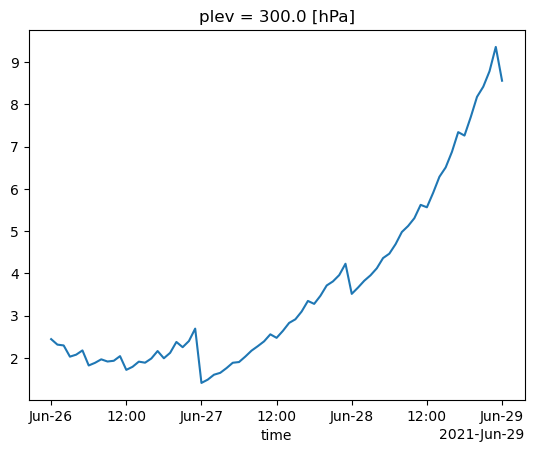

In [3]:
dataset = xr.open_dataset('dataset_paper/pangu1000.nc')
u = dataset['u'].var(dim="ens")
v = dataset['v'].var(dim="ens")
dke = u + v
dke = dke.mean(dim=("lat", "lon"))

# plot in y-axis log scale
dke.plot()

In [ ]:
import xarray as xr
from cdo import Cdo

# CDO instance 생성
cdo = Cdo()

# 파일명 설정
input_file = "dataset.nc"
gaussian_file = "dataset_gaussian.nc"
div_spectral_output = "div_spectral.nc"
vo_spectral_output = "vo_spectral.nc"
dke_spectral_output = "dke_spectral.nc"

# Step 1: Gaussian Grid Interpolation (N360)
cdo.remap("n360", input=input_file, output=gaussian_file)

# Step 2: Calculate Divergence and Vorticity
cdo.div(input=gaussian_file, output=div_spectral_output)
cdo.vor(input=gaussian_file, output=vo_spectral_output)

# Step 3: Calculate Difference Kinetic Energy (DKE) Spectrum
cdo.sqrt(input=f"-add -sqr {div_spectral_output} -sqr {vo_spectral_output}", output=dke_spectral_output)

# Load and inspect the outputs (Optional)
div_spectral = xr.open_dataset(div_spectral_output)
vo_spectral = xr.open_dataset(vo_spectral_output)
dke_spectral = xr.open_dataset(dke_spectral_output)

# 결과 출력 (선택 사항)
print(div_spectral)
print(vo_spectral)
print(dke_spectral)


ModuleNotFoundError: No module named 'cdo'